We aren't given any labels for hit/miss, so I assume we're supposed to predict this ourselves.

I.e. hypothesis: Neuroplasticity becomes stronger from use of FES
 - We can find correlation from EEG signals and movement of robot
 - make our own model to predict and give binary classification matrix/report

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import seaborn as sns
import copy

In [2]:
# constants
fs = 512 # gotten from xdf files

This code is to parse split the messed up session into normal sessions

In [3]:
# run1 = run[run['Trial'] <= 60]
# run2 = run[run['Trial'] > 60]

In [4]:
# # Ensure the DataFrame is sorted by time
# run1_marker = run1.sort_values('Time').reset_index(drop=True)

# # Only keep rows with non-null labels
# label_df = run1_marker[['Time', 'Label']].dropna().copy()

# # Identify where the label changes (i.e., new group starts)
# label_df['PrevLabel'] = label_df['Label'].shift()
# label_df['LabelChange'] = label_df['Label'] != label_df['PrevLabel']

# # Keep only the first row of each new group of the same label
# first_in_group_df = label_df[label_df['LabelChange']].drop(columns=['PrevLabel', 'LabelChange'])

# # Reset index for a clean DataFrame
# run1_marker = first_in_group_df.reset_index(drop=True)

# # Ensure the DataFrame is sorted by time
# run2_marker = run2.sort_values('Time').reset_index(drop=True)

# # Only keep rows with non-null labels
# label_df = run2_marker[['Time', 'Label']].dropna().copy()

# # Identify where the label changes (i.e., new group starts)
# label_df['PrevLabel'] = label_df['Label'].shift()
# label_df['LabelChange'] = label_df['Label'] != label_df['PrevLabel']

# # Keep only the first row of each new group of the same label
# first_in_group_df = label_df[label_df['LabelChange']].drop(columns=['PrevLabel', 'LabelChange'])

# # Reset index for a clean DataFrame
# run2_marker = first_in_group_df.reset_index(drop=True)

In [5]:
# run1_eeg = run1.drop(columns=['Label', 'OutcomeClass', 'Trial'], axis=1)

# run2_eeg = run2.drop(columns=['Label', 'OutcomeClass', 'Trial'], axis=1)

In [6]:
# run1_marker.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv', index=False)
# run2_marker.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg_markers.csv', index=False)
# run1_eeg.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg.csv', index=False)
# run2_eeg.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg.csv', index=False)

code to load data

In [26]:
def run_parse(eeg_df, marker_df, FES):
    eeg_df['Label'] = np.nan

    eeg_df = eeg_df.sort_values('Time')
    marker_df = marker_df.sort_values('Time').reset_index(drop=True)

    for i in range(len(marker_df)):
        t_start = marker_df.loc[i, 'Time']
        label = marker_df.loc[i, 'Label']
        
        if i < len(marker_df) - 1:
            t_end = marker_df.loc[i + 1, 'Time']
        else:
            t_end = np.inf

        eeg_df.loc[(eeg_df['Time'] >= t_start) & (eeg_df['Time'] < t_end), 'Label'] = label

    eeg_df['Label'] = eeg_df['Label'].dropna().astype(float).astype(int).astype(str)

    TRIGGERS = {
        "MI_BEGIN": "200",
        "MI_END": "220",
        "MI_EARLYSTOP": "240",
        "ROBOT_BEGIN": "300",
        "ROBOT_END": "320",
        "ROBOT_EARLYSTOP": "340",
        "ROBOT_CONFIRM_STOP": "345",
        "REST_BEGIN": "100",
        "REST_END": "120",
        "REST_EARLYSTOP": "140"
    }
    label_to_class = {v: k for k, v in TRIGGERS.items()}
    eeg_df['OutcomeClass'] = eeg_df['Label'].map(label_to_class)

    eeg_df['PrevClass'] = eeg_df['OutcomeClass'].shift()
    events_clean = eeg_df[(eeg_df['OutcomeClass'] != eeg_df['PrevClass']) & (eeg_df['OutcomeClass'].notna())].copy()
    events_clean = events_clean[['Time', 'OutcomeClass']].reset_index(drop=True)

    trial_begins = events_clean[events_clean['OutcomeClass'].isin(['MI_BEGIN', 'REST_BEGIN'])].reset_index(drop=True)

    eeg_df['Trial'] = np.nan
    trial_num = 0

    for i in range(len(trial_begins)):
        t_start = trial_begins.loc[i, 'Time']
        if i < len(trial_begins) - 1:
            t_end = trial_begins.loc[i + 1, 'Time']
        else:
            t_end = np.inf
        eeg_df.loc[(eeg_df['Time'] >= t_start) & (eeg_df['Time'] < t_end), 'Trial'] = trial_num
        trial_num += 1

    first_start = trial_begins['Time'].min()
    eeg_df.loc[eeg_df['Time'] < first_start, 'Trial'] = -1
    eeg_df['Trial'] = eeg_df['Trial'].astype(int)

    eeg_df['FES'] = FES

    # === HIT and Timeout logic ===
    eeg_df['HIT'] = 0
    eeg_df['Timeout'] = 0
    grouped = eeg_df[eeg_df['OutcomeClass'].notna()].groupby('Trial')['OutcomeClass'].apply(list)

    for trial, events in grouped.items():
        is_mi = 'MI_BEGIN' in events
        is_rest = 'REST_BEGIN' in events

        earlystop = 'MI_EARLYSTOP' in events or 'REST_EARLYSTOP' in events
        end = 'MI_END' in events or 'REST_END' in events

        # HIT: early stop occurred
        if earlystop and (is_mi or is_rest):
            eeg_df.loc[eeg_df['Trial'] == trial, 'HIT'] = 1
            eeg_df.loc[eeg_df['Trial'] == trial, 'Timeout'] = 0  # not a timeout
        # Timeout: end occurred with no early stop
        elif end and not earlystop and (is_mi or is_rest):
            eeg_df.loc[eeg_df['Trial'] == trial, 'HIT'] = 0
            eeg_df.loc[eeg_df['Trial'] == trial, 'Timeout'] = 1
        # Neither: no HIT and no timeout
        else:
            eeg_df.loc[eeg_df['Trial'] == trial, ['HIT', 'Timeout']] = 0

    eeg_df['Outcome'] = eeg_df['HIT'].apply(lambda x: 'HIT' if x == 1 else 'MISS')

    return eeg_df.drop(['PrevClass'], axis=1)


In [4]:
sample_marker = pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv')

In [7]:
TRIGGERS = {
    "MI_BEGIN": "200",
    "MI_END": "220",
    "MI_EARLYSTOP": "240",
    "ROBOT_BEGIN": "300",
    "ROBOT_END": "320",
    "ROBOT_EARLYSTOP": "340",
    "ROBOT_CONFIRM_STOP": "345",
    "REST_BEGIN": "100",
    "REST_END": "120",
    "REST_EARLYSTOP": "140",
}
trigger_map = {v: k for k, v in TRIGGERS.items()}
sample_marker['Label_String'] = sample_marker['Label'].astype(str).map(trigger_map)
sample_marker['Label_String'].to_list()

['MI_BEGIN',
 'MI_EARLYSTOP',
 'MI_END',
 'ROBOT_BEGIN',
 'ROBOT_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_END',
 'MI_BEGIN',
 'MI_END',
 'REST_BEGIN',
 'REST_EARLYSTOP',
 'REST_END',
 'MI_BEGIN',
 'MI_EARLYSTOP',
 'MI_END',
 'ROBOT_BEGIN',
 'ROBOT_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_EARLYSTOP',
 'MI_END',
 'ROBOT_BEGIN',
 'ROBOT_END',
 'REST_BEGIN',
 'REST_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_END',
 'MI_BEGIN',
 'MI_END',
 'REST_BEGIN',
 'REST_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_END',
 'MI_BEGIN',
 'MI_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_EARLYSTOP',
 'MI_END',
 'ROBOT_BEGIN',
 'ROBOT_END',
 'MI_BEGIN',
 'MI_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_EARLYSTOP',
 'MI_END',
 'ROBOT_BEGIN',
 'ROBOT_END',
 'MI_BEGIN',
 'MI_END',
 'REST_BEGIN',
 'REST_END',
 'REST_BEGIN',
 'REST_EARLYSTOP',
 'REST_END',
 'REST_BEGIN',
 'REST_END',
 'MI_BEGIN',
 'MI_EARLYSTOP

In [8]:
sample_marker['Label'].to_list()

[200,
 240,
 220,
 300,
 320,
 100,
 120,
 200,
 220,
 200,
 220,
 100,
 140,
 120,
 200,
 240,
 220,
 300,
 320,
 100,
 120,
 200,
 240,
 220,
 300,
 320,
 100,
 120,
 100,
 120,
 200,
 220,
 200,
 220,
 100,
 120,
 100,
 120,
 200,
 220,
 200,
 220,
 100,
 120,
 200,
 240,
 220,
 300,
 320,
 200,
 220,
 100,
 120,
 200,
 220,
 100,
 120,
 200,
 240,
 220,
 300,
 320,
 200,
 220,
 100,
 120,
 100,
 140,
 120,
 100,
 120,
 200,
 240,
 220,
 300,
 320,
 100,
 140,
 120,
 200,
 220,
 100,
 140,
 120,
 200,
 220,
 100,
 140,
 120,
 100,
 120,
 100,
 140,
 120,
 200,
 220,
 200,
 220,
 100,
 120,
 100,
 120,
 100,
 120,
 200,
 220,
 100,
 120,
 100,
 140,
 120,
 100,
 120,
 200,
 220,
 200,
 240,
 220,
 300,
 320,
 200,
 220,
 100,
 140,
 120,
 200,
 220,
 100,
 120,
 200,
 220,
 200,
 240,
 220,
 300,
 320,
 200,
 220,
 100,
 140,
 120,
 100,
 140,
 120,
 200,
 220,
 100,
 120,
 200,
 220,
 200,
 240,
 220,
 300,
 320,
 200,
 240,
 220,
 300,
 320,
 100,
 140,
 120]

In [27]:
subjects = {'Subj1031': {'Online': {'Sessions': [{'Runs': []}, {'Runs': []}]}, 'Offline': {'Sessions': [{'Runs': []}, {'Runs': []}]}}, 'Subj1032': {'Online': {'Sessions': [{'Runs': []}, {'Runs': []}]}, 'Offline': {'Sessions': [{'Runs': []}, {'Runs': []}]}}, 'Subj1033': {'Online': {'Sessions': [{'Runs': []}, {'Runs': []}]}, 'Offline': {'Sessions': [{'Runs': []}, {'Runs': []}]}}}

In [28]:
subjects['Subj1031']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
# subjects['Subj1031']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
# subjects['Subj1031']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
# subjects['Subj1031']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
# subjects['Subj1031']['Offline']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001OFFLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001OFFLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
# subjects['Subj1031']['Offline']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))

In [31]:
subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].sample()

Time      Ch1     Ch2     Ch3      Ch4      Ch5      Ch6  \
117646  24134.021601 -2546.01  204.47 -3169.8 -5576.37 -4117.62  3248.41   

            Ch7      Ch8      Ch9  ...       Ch37      Ch38  Ch39  Label  \
117646 -4615.76 -6305.97 -1272.42  ... -34613.892 -3435.493   0.0    120   

        OutcomeClass  Trial   FES  HIT  Timeout  Outcome  
117646      REST_END     12  True    0        1     MISS  

[1 rows x 47 columns]

In [11]:
subjects['Subj1032']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1032']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1032']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1032']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1032']['Offline']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001OFFLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001OFFLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1032']['Offline']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))

In [12]:
subjects['Subj1033']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1033']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1033']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1033']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1033']['Offline']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_OFFLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_OFFLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1033']['Offline']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))

trial data is from rest/mi begin to end, but this excludes most of the data. So, I just included all of the data in the trial (until the next begin). To only look at trial data:

In [13]:
trial_labels = {'REST_BEGIN', 'REST_EARLYSTOP', 'REST_END', 'MI_BEGIN', 'MI_EARLYSTOP', 'MI_END'}
# trial_eeg_df = eeg_df[eeg_df['OutcomeClass'].isin(trial_labels)]
# trial_eeg_df.shape

Data Analysis

In [13]:
subjects_trials_only = copy.deepcopy(subjects)
# just making a copy of subjects to hold only trial data
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1][subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]

subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1][subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]

subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1][subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]

In [14]:
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].head()

Time      Ch1    Ch2      Ch3      Ch4      Ch5      Ch6  \
19240  23941.821764 -2365.96  45.32 -3188.72 -5350.79 -4007.19  3210.48   
19241  23941.823717 -2370.93  42.81 -3198.69 -5366.82 -4011.52  3210.99   
19242  23941.825670 -2370.22  50.58 -3177.79 -5384.10 -4014.51  3218.63   
19243  23941.827623 -2369.74  49.98 -3175.64 -5358.62 -4010.60  3218.20   
19244  23941.829576 -2373.57  49.41 -3179.13 -5374.62 -4015.94  3216.03   

           Ch7      Ch8     Ch9  ...       Ch34       Ch35      Ch36  \
19240 -4329.20 -6627.75 -709.09  ... -17012.969 -15310.793 -5133.646   
19241 -4322.41 -6631.79 -716.51  ... -17028.614 -15332.845 -5129.623   
19242 -4302.49 -6570.18 -722.89  ... -17023.548 -15334.186 -5141.990   
19243 -4307.44 -6572.16 -718.33  ... -17031.594 -15316.008 -5148.546   
19244 -4314.02 -6601.22 -721.31  ... -17011.330 -15271.010 -5154.059   

            Ch37      Ch38  Ch39  Label  OutcomeClass  Trial   FES  
19240 -34597.353 -3362.781   0.0    200      MI_BEGIN      0  True  
19241 -34608.081 -3396.306   0.0    200      MI_BEGIN      0  True  
19242 -34605.995 -3411.206   0.0    200      MI_BEGIN      0  True  
19243 -34604.356 -3427.596   0.0    200      MI_BEGIN      0  True  
19244 -34612.849 -3411.951   0.0    200      MI_BEGIN      0  True  

[5 rows x 44 columns]

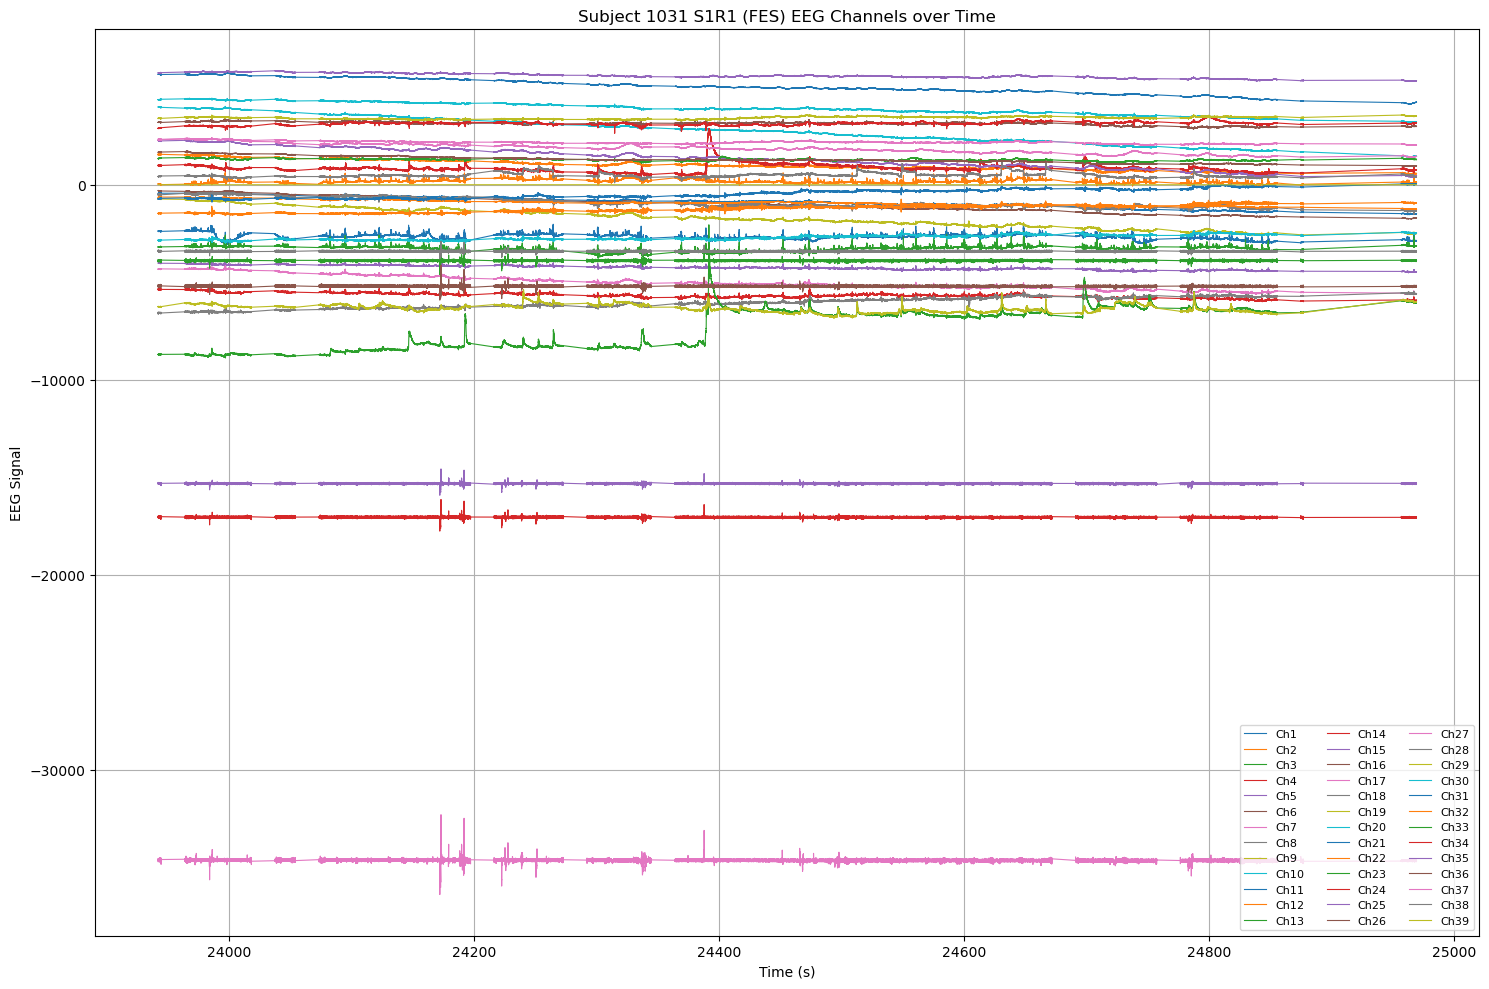

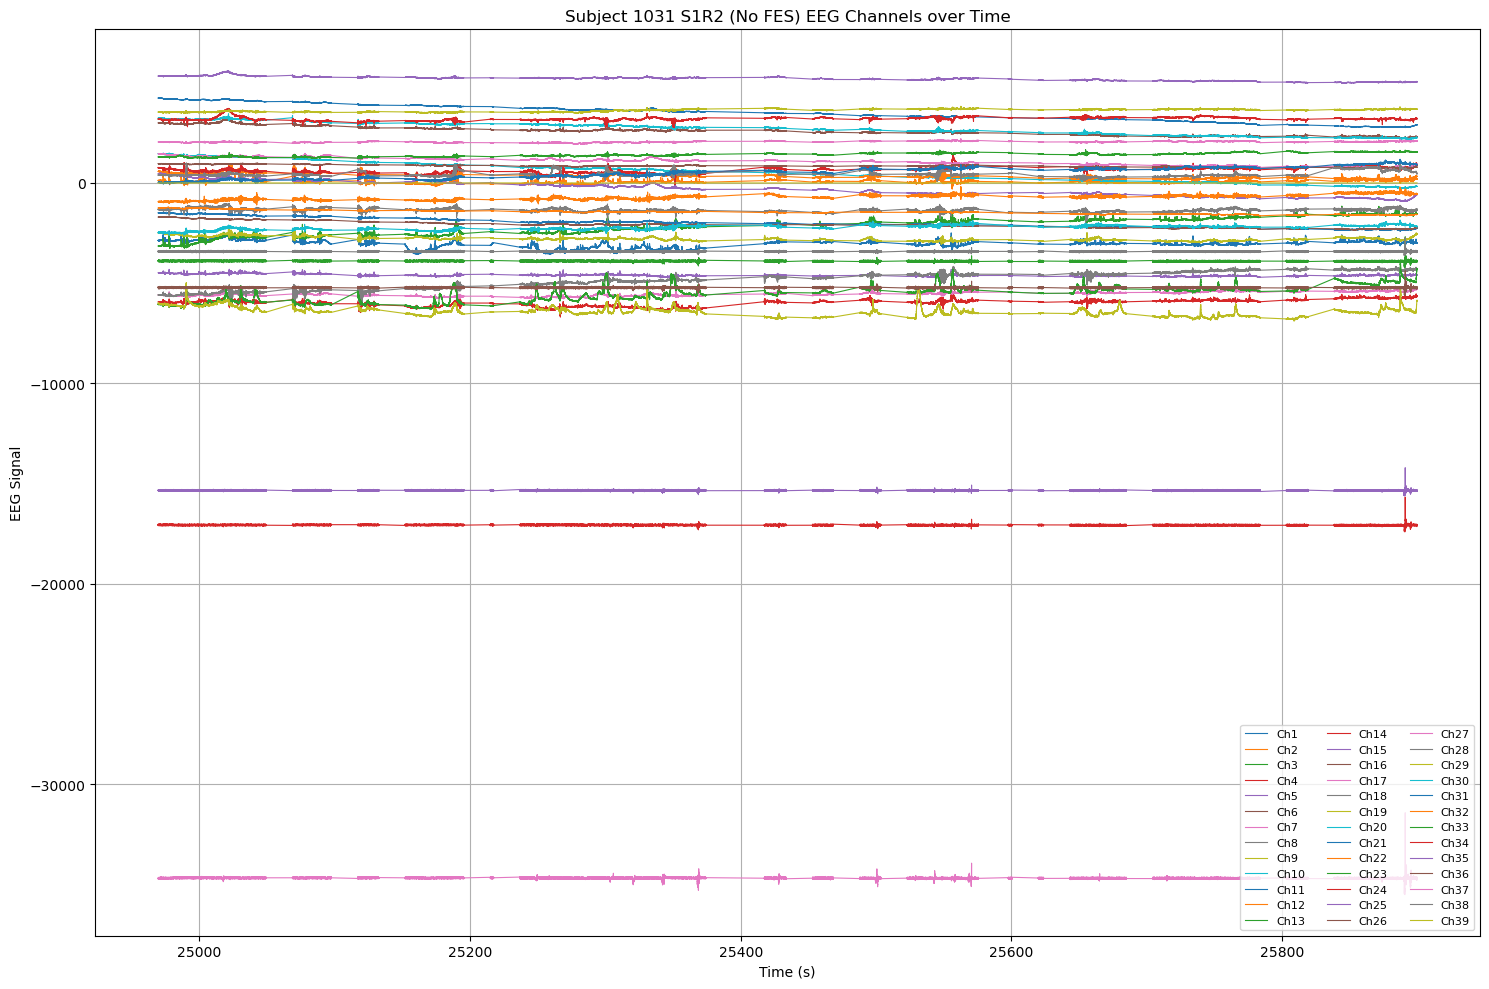

In [15]:
channel_cols = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1031 S1R1 (FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

channel_cols = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1031 S1R2 (No FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

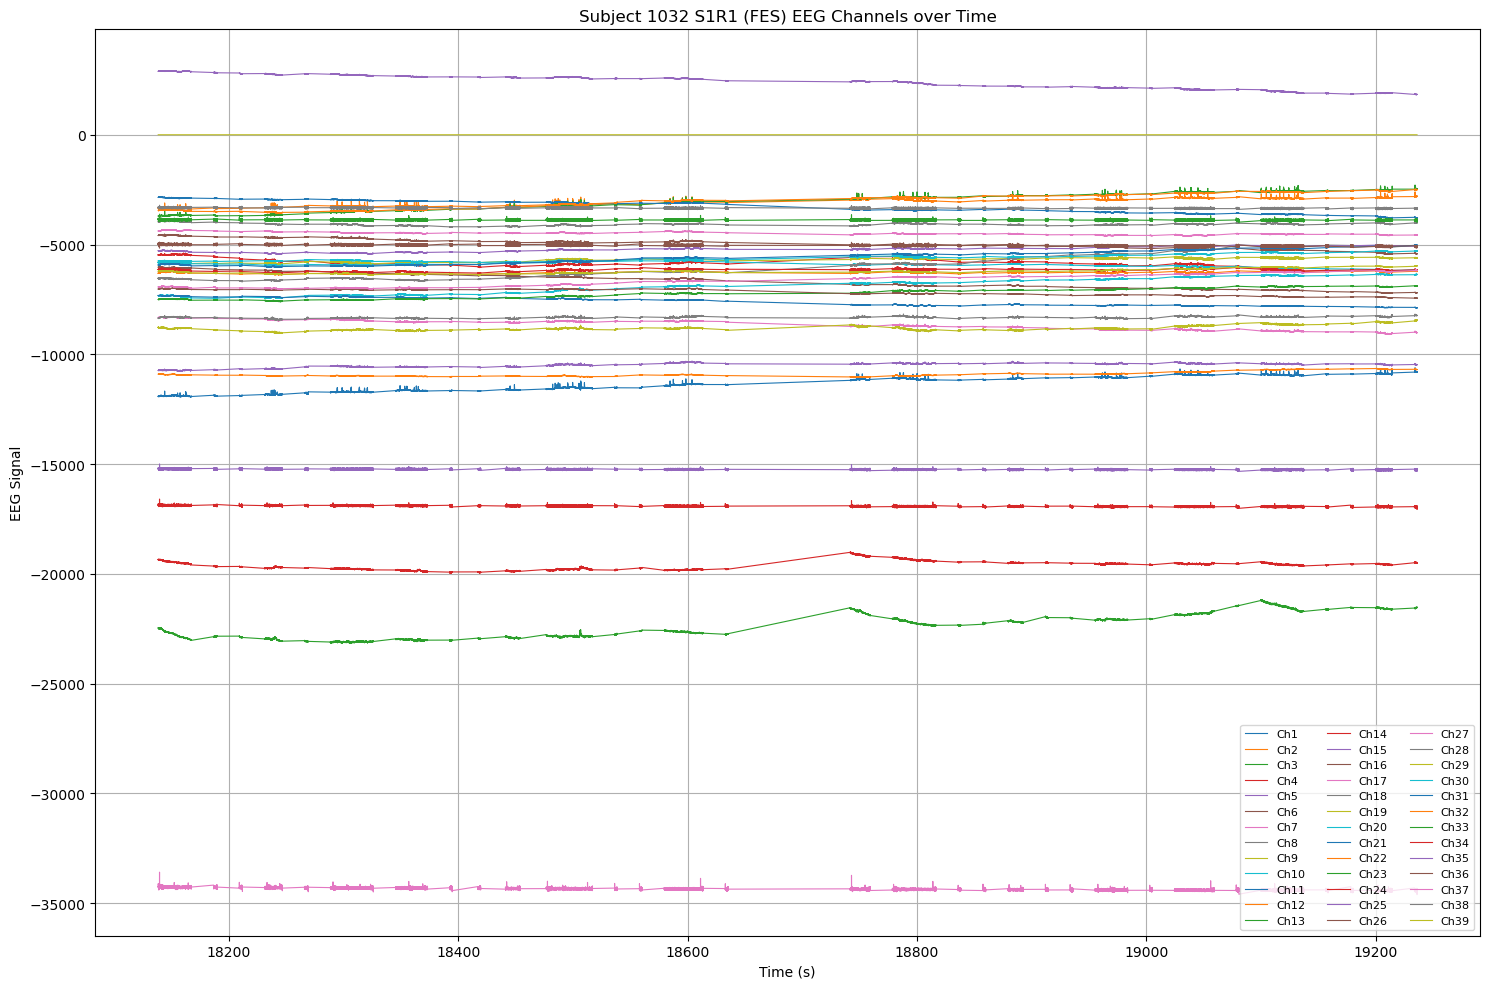

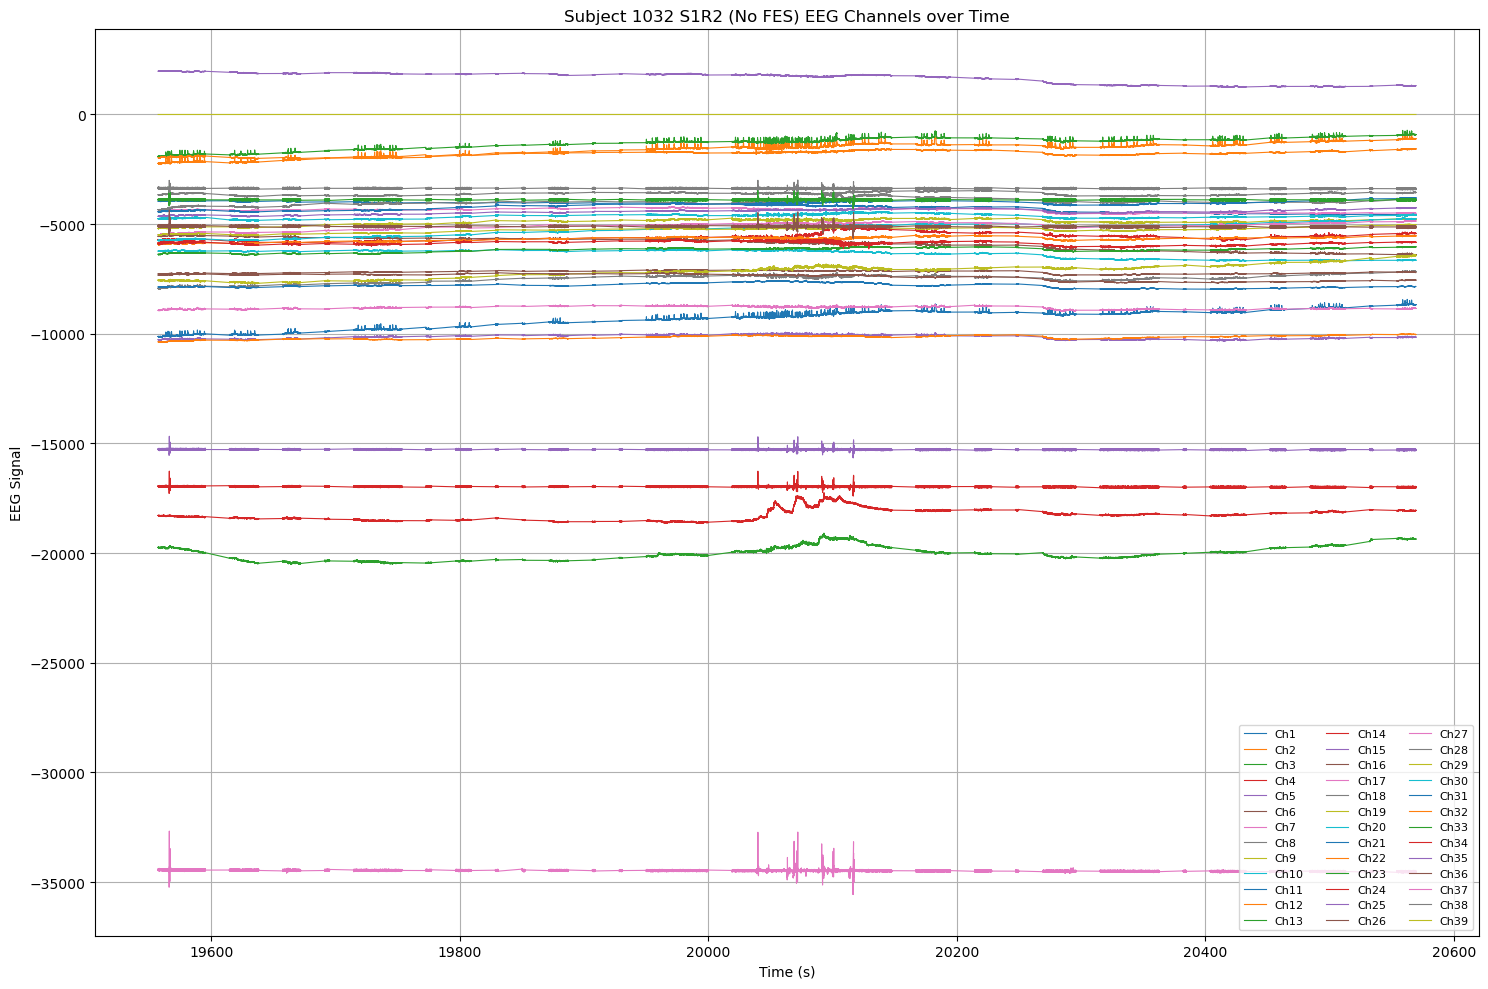

In [16]:
channel_cols = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1032 S1R1 (FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

channel_cols = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1032 S1R2 (No FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

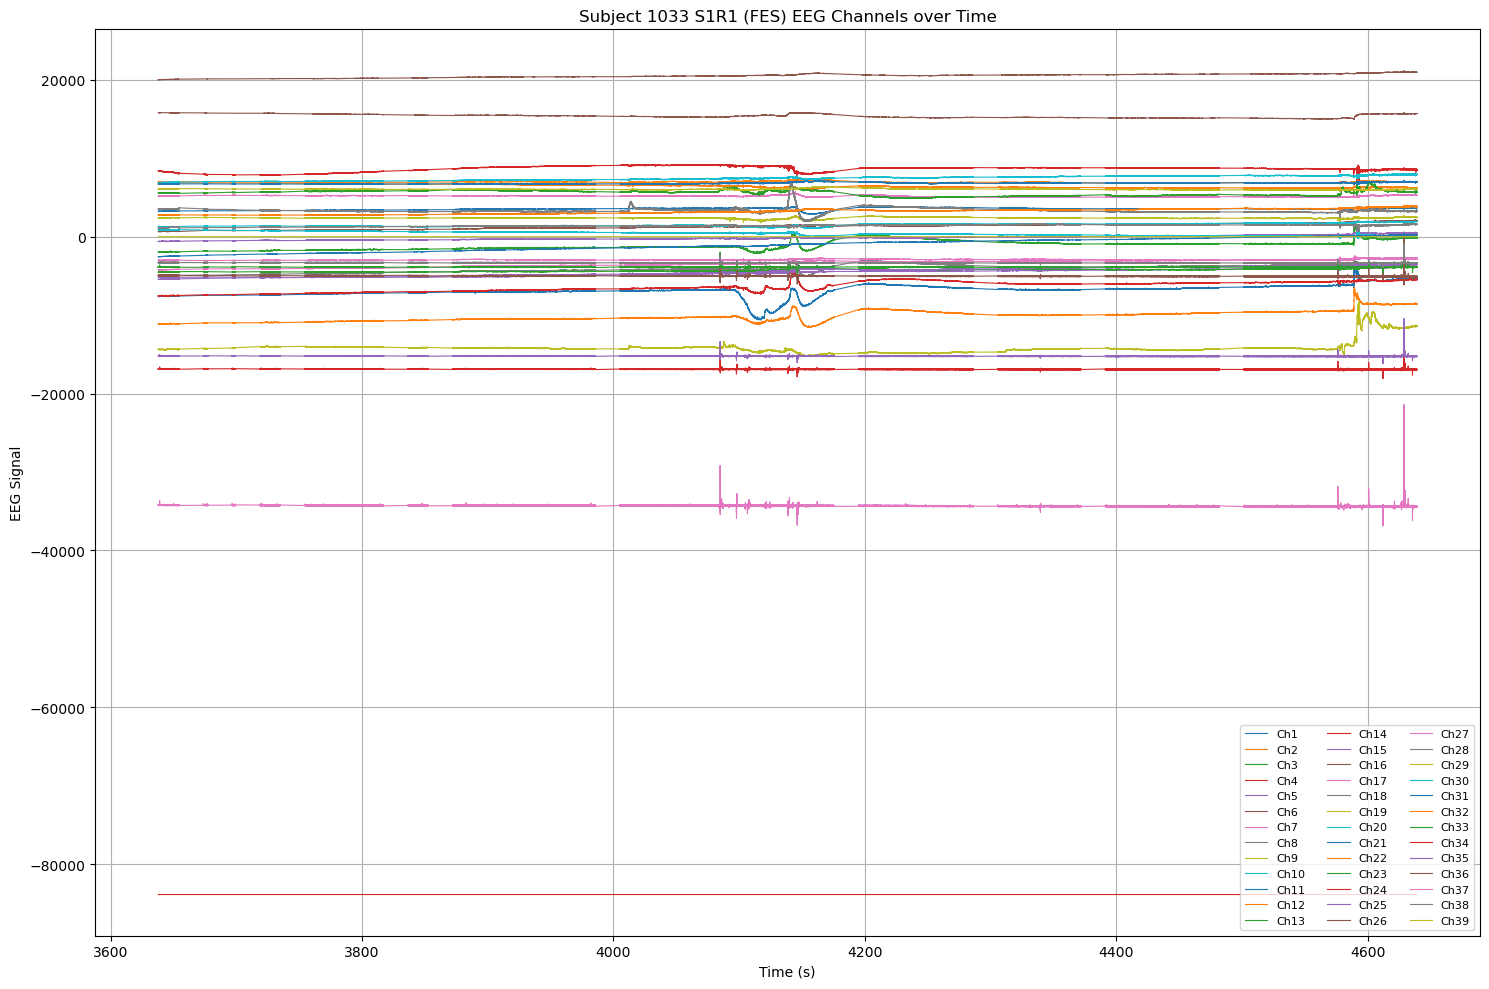

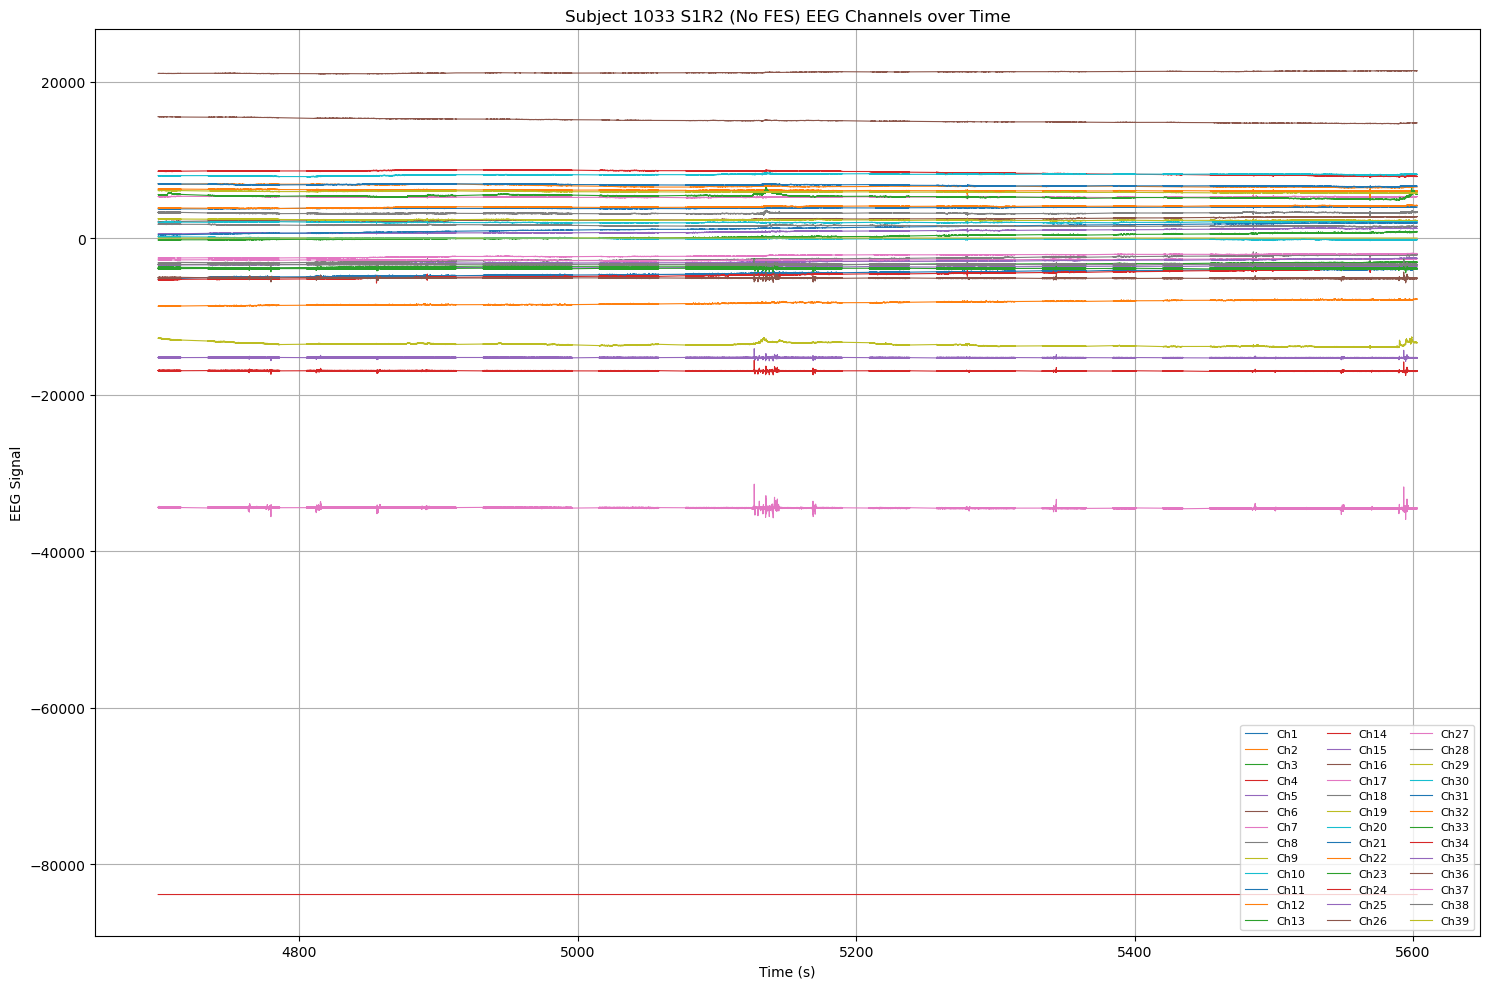

In [17]:
channel_cols = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1033 S1R1 (FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

channel_cols = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1033 S1R2 (No FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

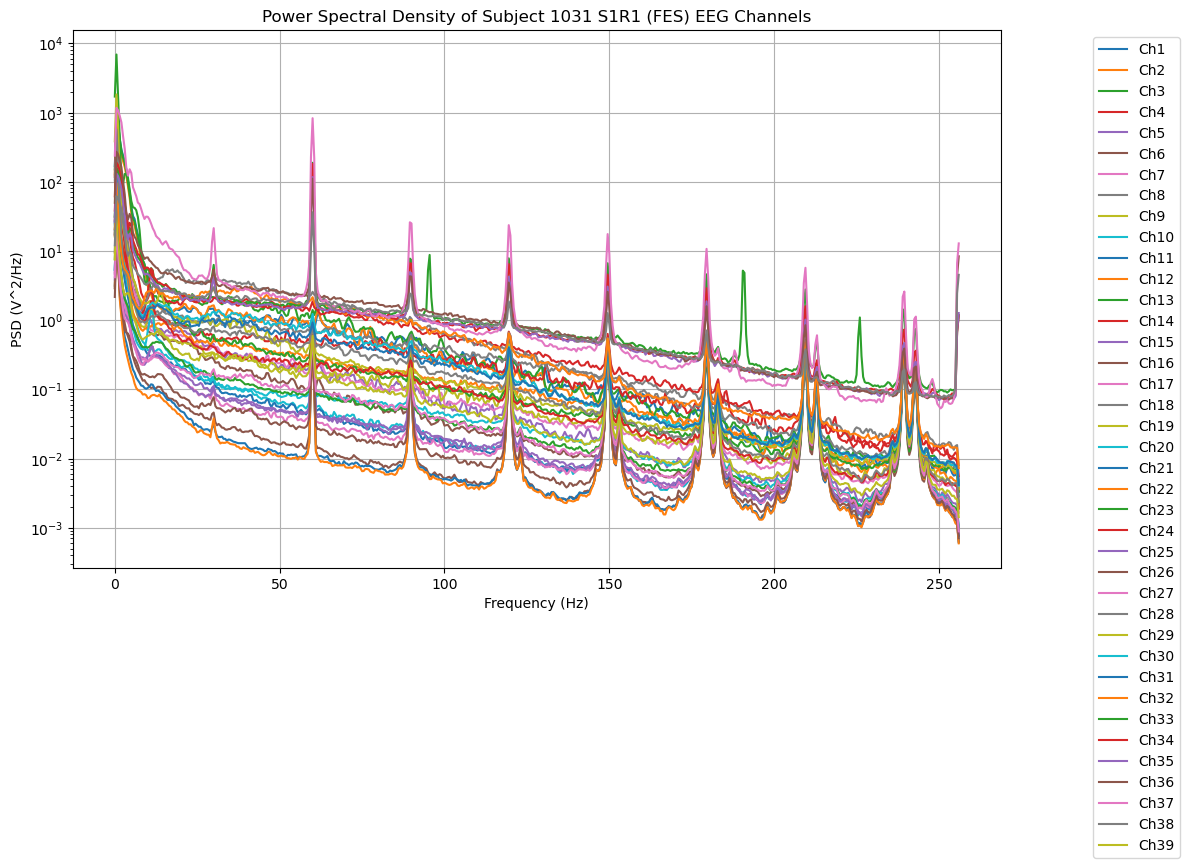

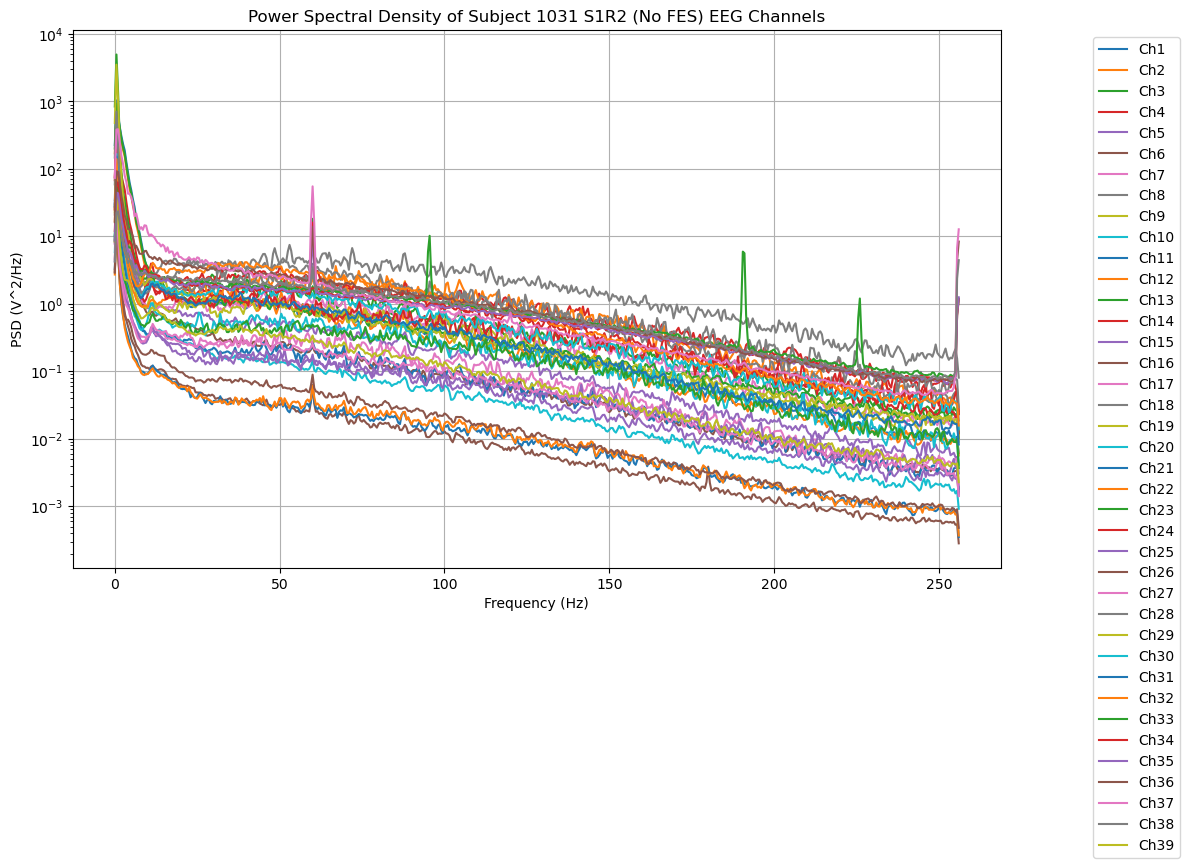

In [18]:
eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

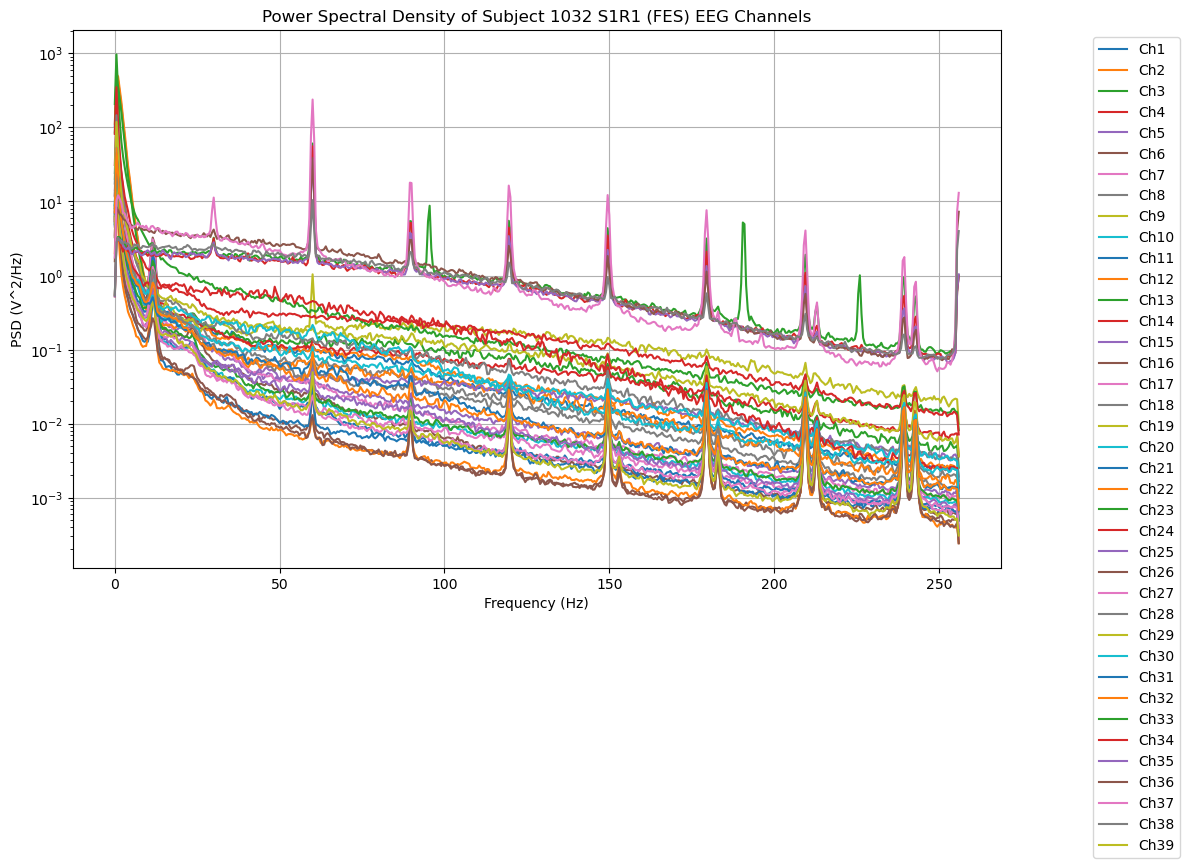

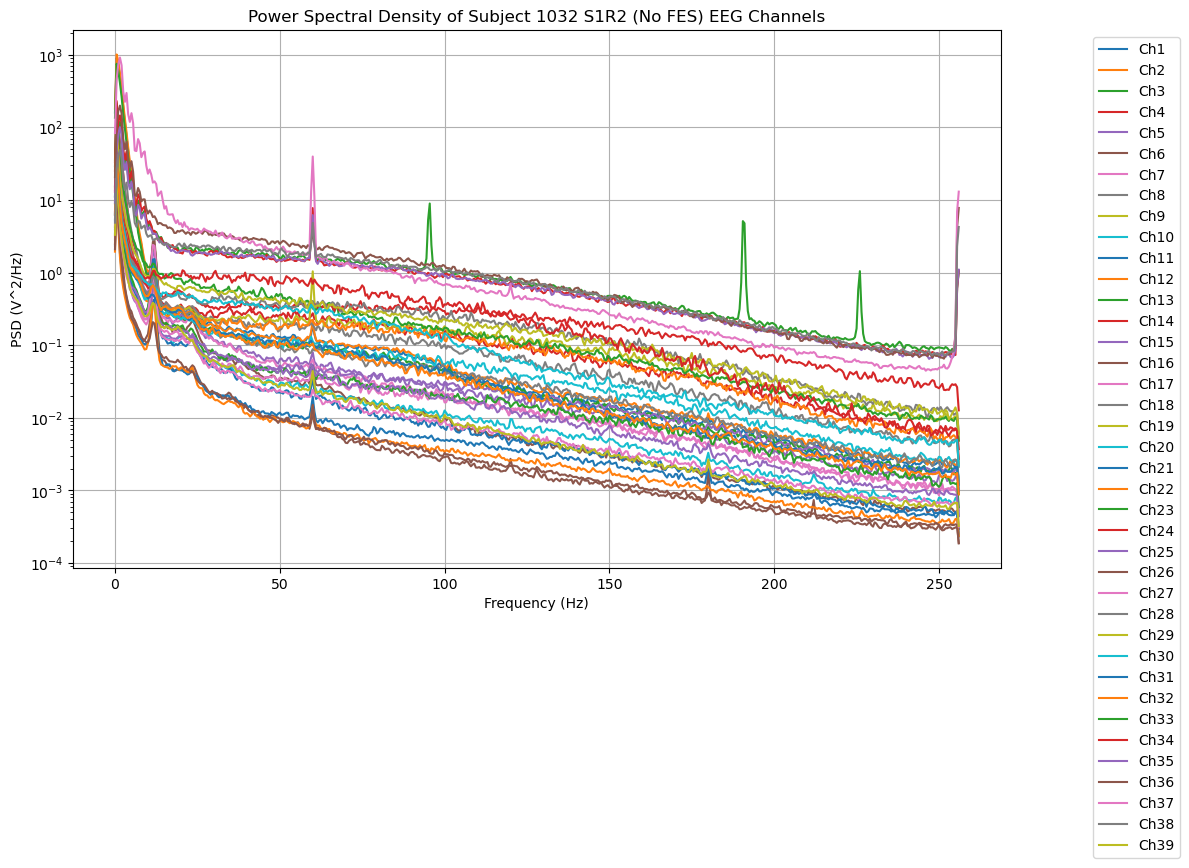

In [19]:
eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

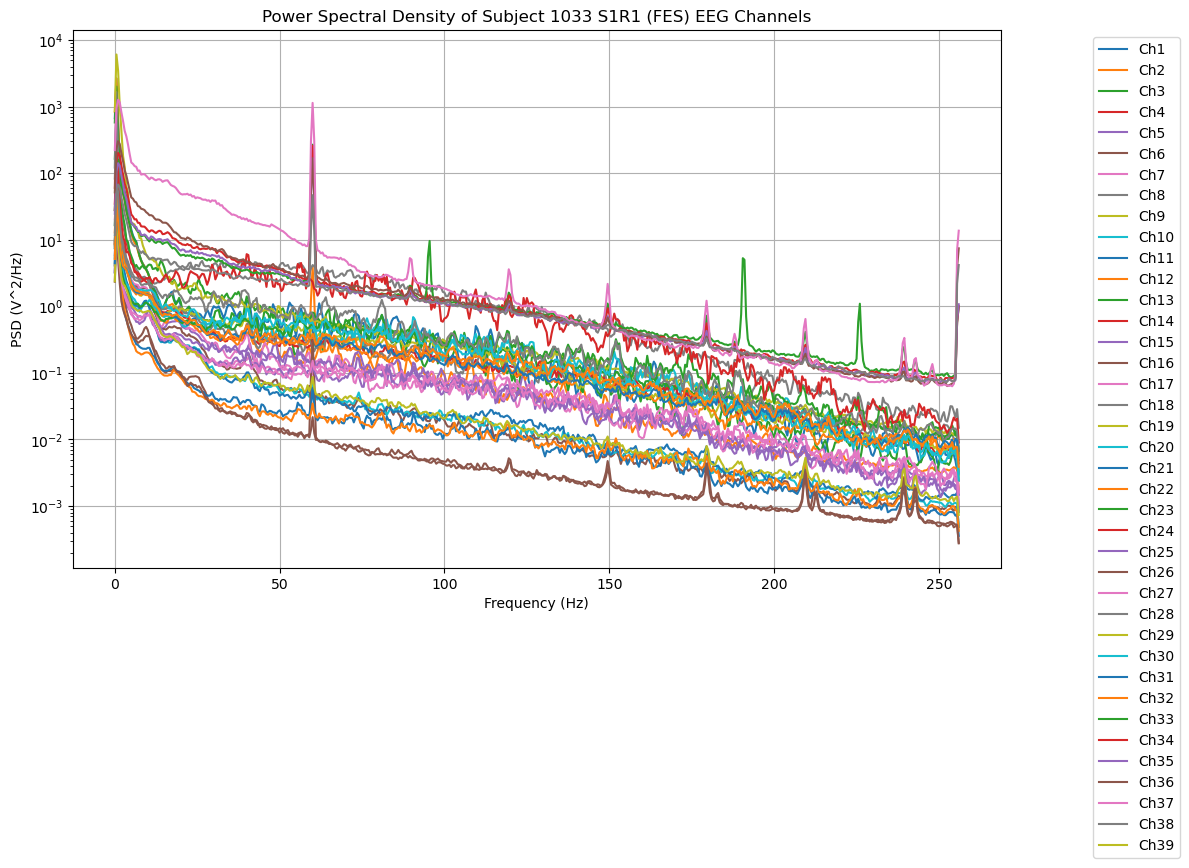

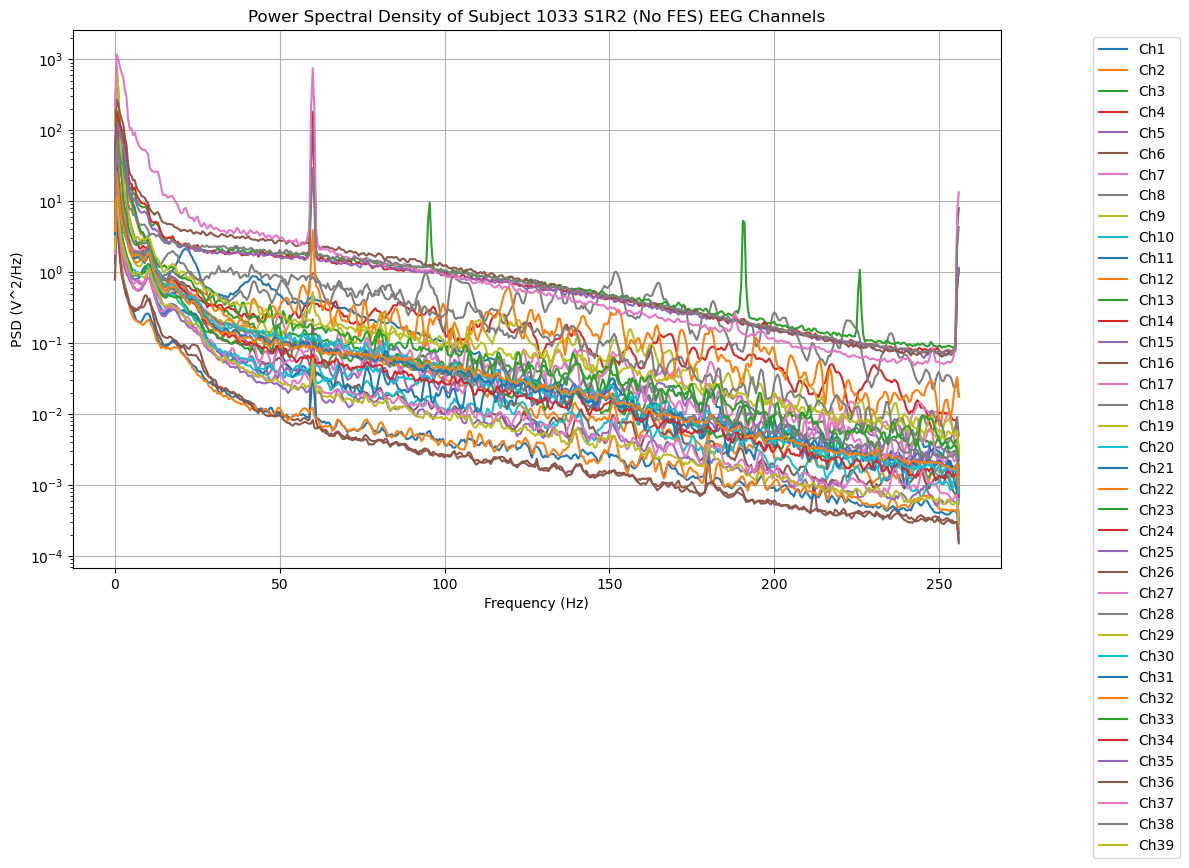

In [20]:
eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

See lots of noise in first ~30 hz and last ~20Hz so will filter to 30-250

In [21]:
def filter_channels(df, lowpass, highpass):
    def bandpass_filter(data, lowpass, highpass, fs, order=4):
        nyquist = 0.5 * fs
        low = lowpass / nyquist
        high = highpass / nyquist

        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data)
        return y
    
    eeg_channels = [col for col in df.columns if col.startswith('Ch')]

    for ch in eeg_channels:
        df[ch] = bandpass_filter(df[ch], lowpass, highpass, fs)
    
    return df
        

In [22]:
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = filter_channels(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0], 30, 250)
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = filter_channels(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1], 30, 250)
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = filter_channels(subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0], 30, 250)
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = filter_channels(subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1], 30, 250)
subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = filter_channels(subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0], 30, 250)
subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = filter_channels(subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0], 30, 250)

In [23]:
subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = filter_channels(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0], 30, 250)
subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = filter_channels(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1], 30, 250)
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = filter_channels(subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0], 30, 250)
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = filter_channels(subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1], 30, 250)
subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = filter_channels(subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0], 30, 250)
subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = filter_channels(subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0], 30, 250)

In [24]:
subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = filter_channels(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0], 30, 250)
subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = filter_channels(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1], 30, 250)
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = filter_channels(subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0], 30, 250)
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = filter_channels(subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1], 30, 250)
subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = filter_channels(subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0], 30, 250)
subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = filter_channels(subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0], 30, 250)

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\459744745.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)


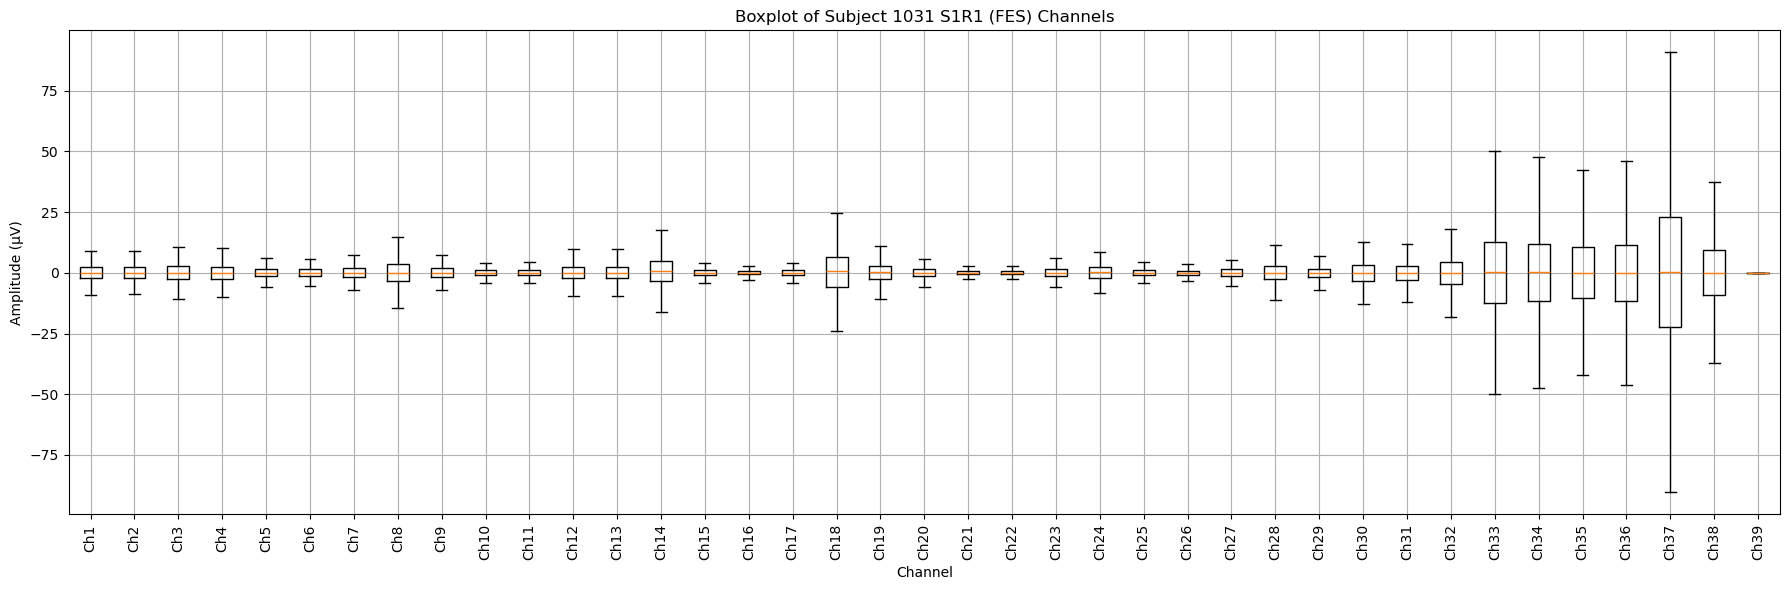

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\459744745.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)


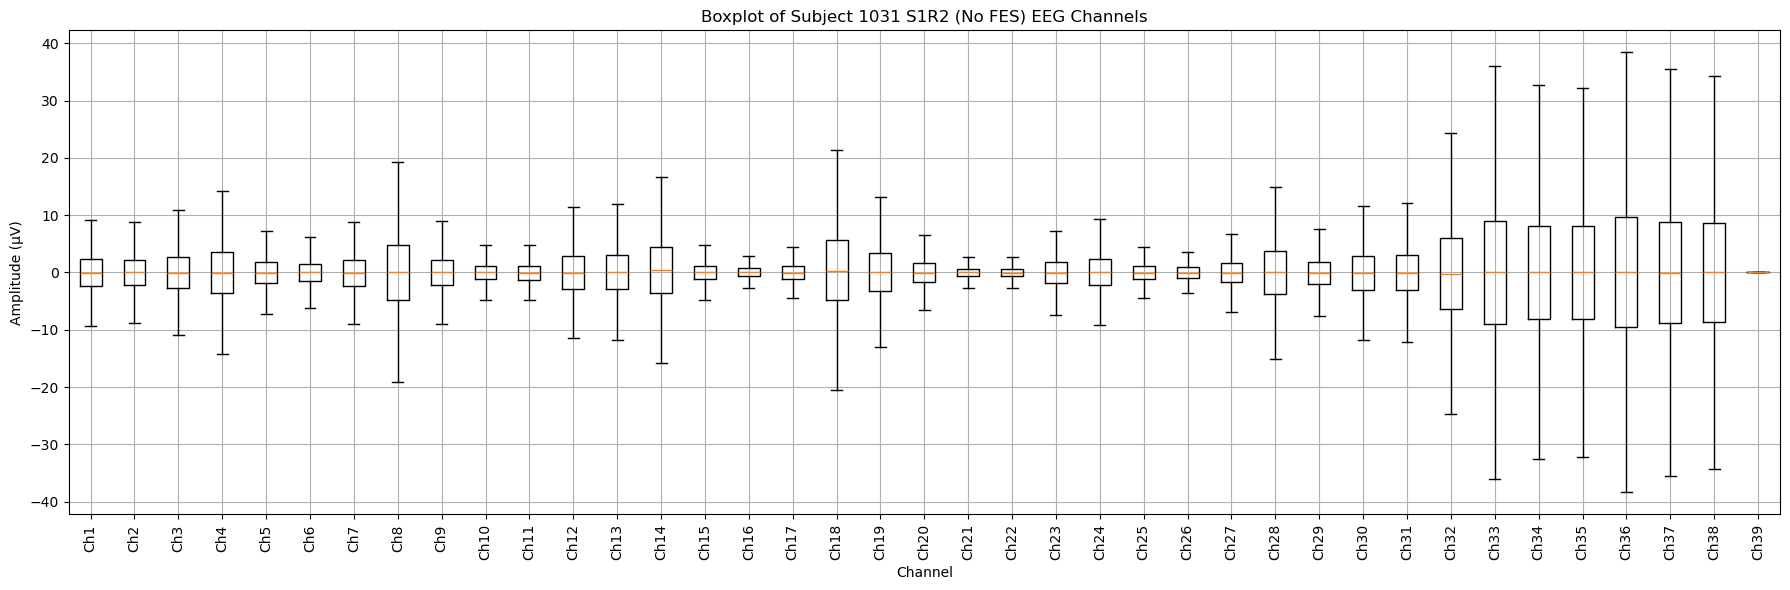

In [25]:
eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

# Create the boxplot
plt.figure(figsize=(18, 6))
plt.boxplot([subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)

plt.title('Boxplot of Subject 1031 S1R1 (FES) Channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

# Create the boxplot
plt.figure(figsize=(18, 6))
plt.boxplot([subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)

plt.title('Boxplot of Subject 1031 S1R2 (No FES) EEG Channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\2463061632.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)


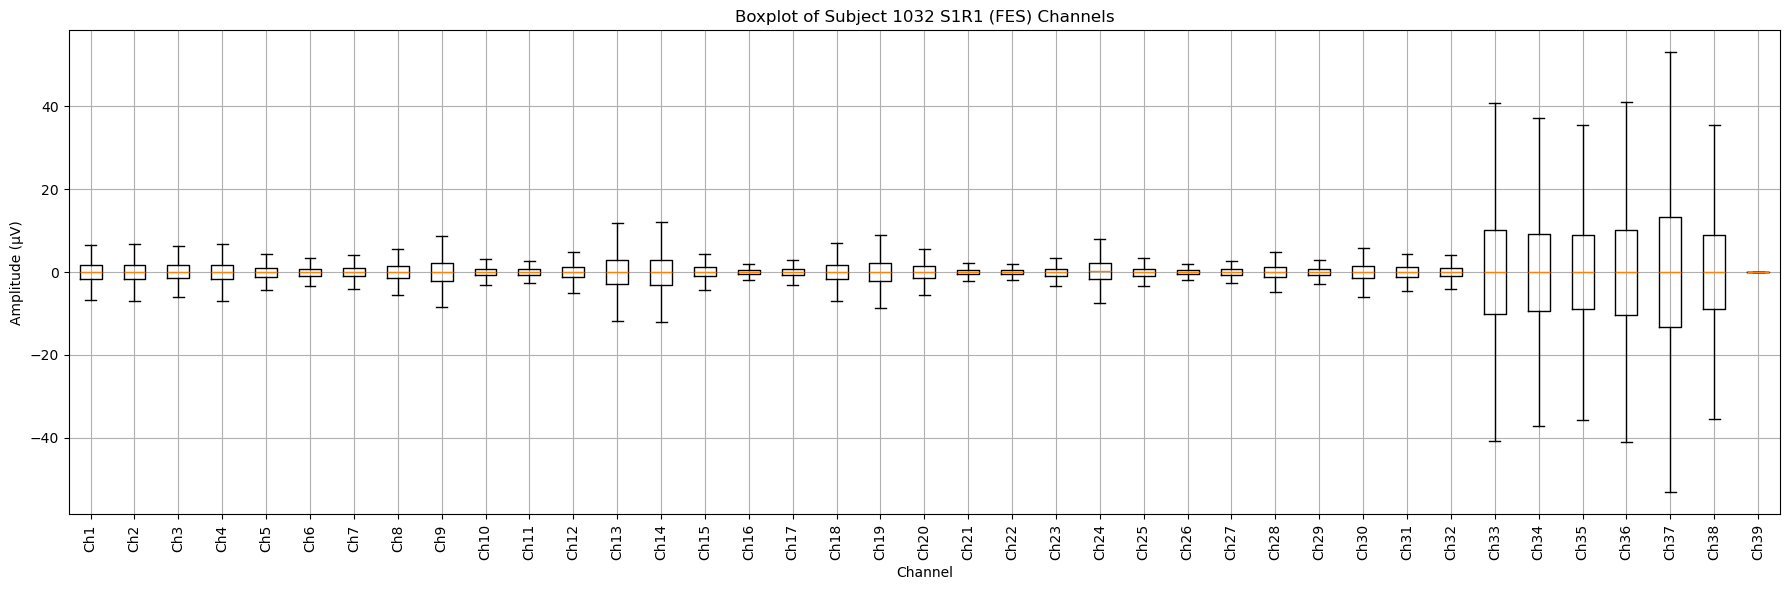

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\2463061632.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)


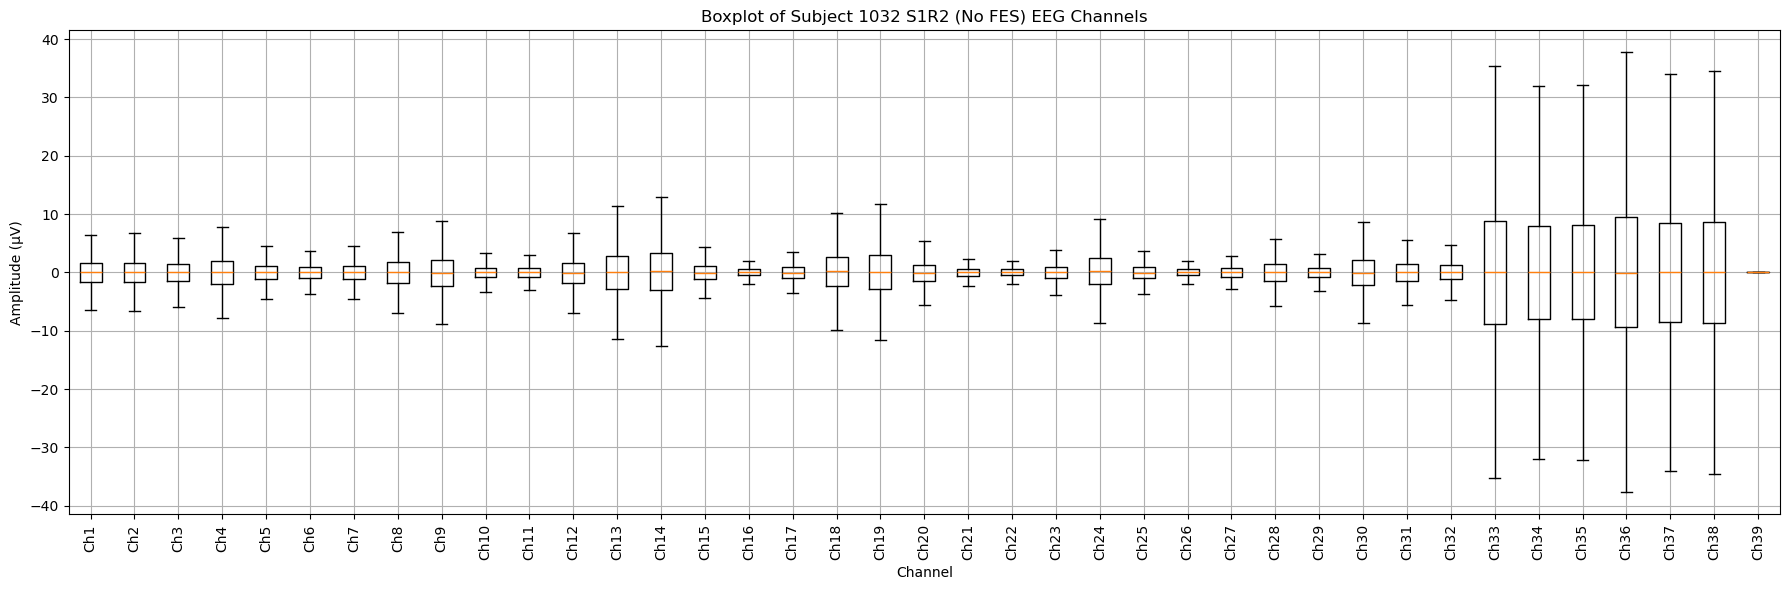

In [26]:
eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

# Create the boxplot
plt.figure(figsize=(18, 6))
plt.boxplot([subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)

plt.title('Boxplot of Subject 1032 S1R1 (FES) Channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

# Create the boxplot
plt.figure(figsize=(18, 6))
plt.boxplot([subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)

plt.title('Boxplot of Subject 1032 S1R2 (No FES) EEG Channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\2094964465.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)


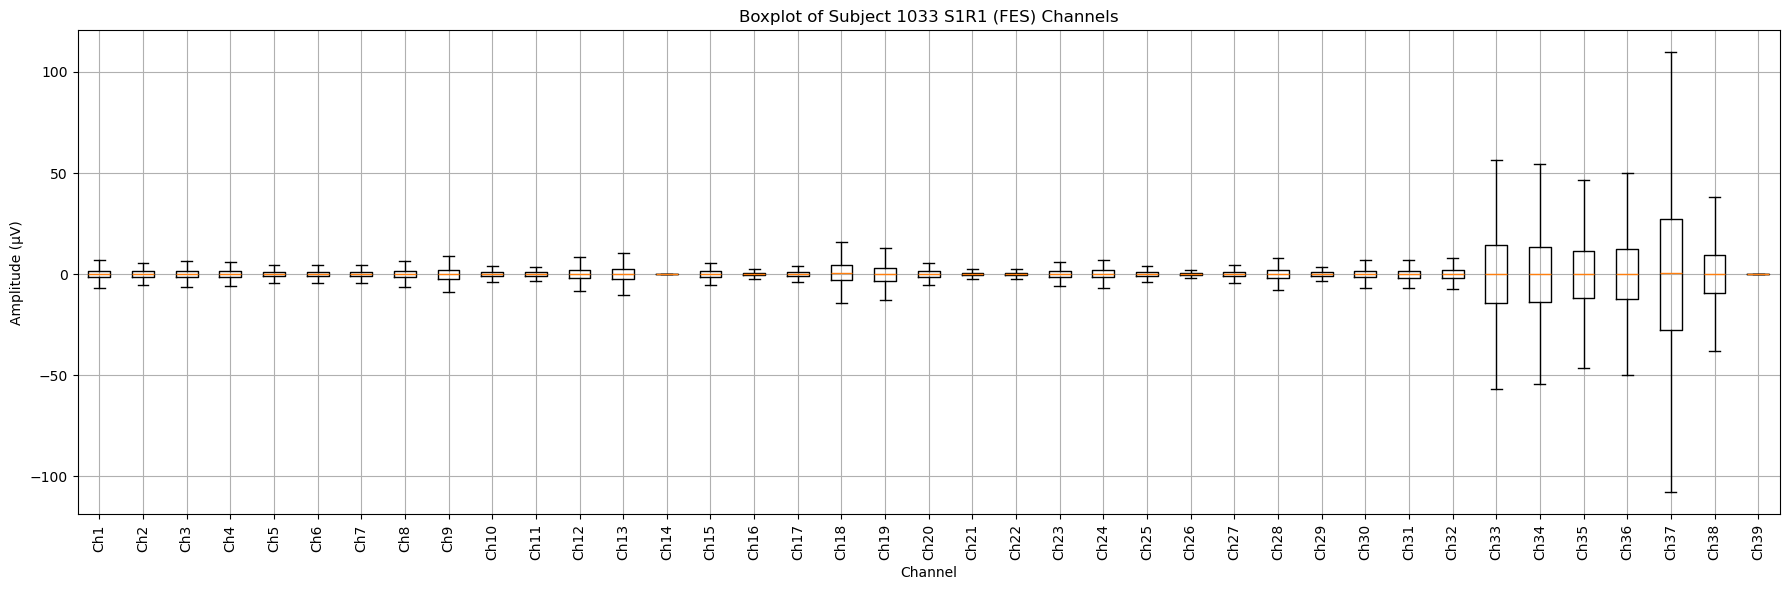

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\2094964465.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)


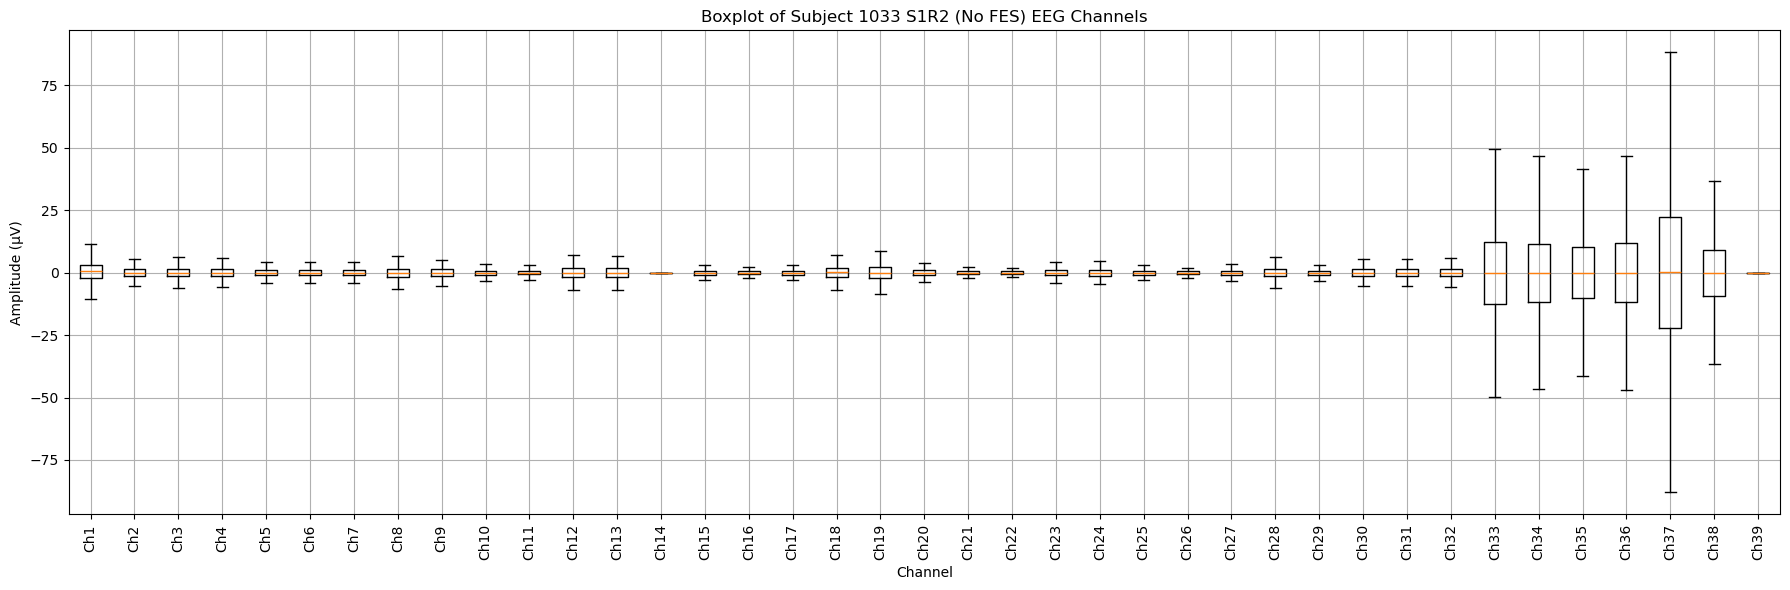

In [27]:
eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col.startswith('Ch')]

# Create the boxplot
plt.figure(figsize=(18, 6))
plt.boxplot([subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)

plt.title('Boxplot of Subject 1033 S1R1 (FES) Channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col.startswith('Ch')]

# Create the boxplot
plt.figure(figsize=(18, 6))
plt.boxplot([subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch] for ch in eeg_channels], labels=eeg_channels, showfliers=False)

plt.title('Boxplot of Subject 1033 S1R2 (No FES) EEG Channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

In [28]:
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

In [34]:
def extract_psd_features(eeg_df, sampling_rate, band_start=0, band_end=250, band_width=10):
    assert 'Trial' in eeg_df.columns, "'Trial' column is required in the input dataframe."

    channel_cols = [col for col in eeg_df.columns if col.startswith('Ch')]
    metadata_cols = [col for col in eeg_df.columns if col not in channel_cols]

    bands = np.arange(band_start, band_end, band_width)
    all_features = []

    for trial_id, trial_df in eeg_df.groupby('Trial'):
        trial_features = {'Trial': trial_id}
        eeg_data = trial_df[channel_cols].to_numpy().T  # shape: (n_channels, n_samples)
        f, Pxx = welch(eeg_data, fs=sampling_rate, nperseg=1024, axis=1)

        for ch_idx, ch_name in enumerate(channel_cols):
            for i in range(len(bands)):
                low = bands[i]
                high = low + band_width
                mask = (f >= low) & (f < high)
                band_power = np.mean(Pxx[ch_idx, mask]) if np.any(mask) else 0.0
                feature_name = f"{ch_name}_{low}-{high}Hz"
                trial_features[feature_name] = band_power

        for col in metadata_cols:
            trial_features[col] = trial_df[col].iloc[0]

        all_features.append(trial_features)

    return pd.DataFrame(all_features)


In [33]:
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].tail()

Time       Ch1       Ch2       Ch3       Ch4       Ch5  \
545447  24969.573116 -1.413300 -0.896360 -2.530110 -0.183647 -1.379659   
545448  24969.575069 -0.622654 -0.991351 -1.709980  0.004951 -1.889015   
545449  24969.577022  0.167134 -0.314054 -1.161722 -2.727544 -2.328947   
545450  24969.578976 -0.349320 -0.427106  0.625715 -2.800490 -1.551548   
545451  24969.580929 -0.076710 -0.031436 -0.117586 -0.097667 -0.047342   

             Ch6       Ch7       Ch8       Ch9  ...      Ch35       Ch36  \
545447 -1.010847 -1.722829 -1.296018 -1.276913  ... -2.532680  24.429336   
545448 -0.415559  0.305021  0.373593 -0.462708  ...  2.168347  24.457156   
545449 -1.352149 -0.752271  1.576807 -1.812527  ...  6.986606   0.802942   
545450 -0.578782 -0.184064  3.202571 -1.872213  ...  3.316493  -7.093825   
545451  0.034062  0.088131  0.087730 -0.031678  ...  0.452408   0.023708   

             Ch37      Ch38  Ch39  Label  OutcomeClass  Trial   FES  Is_MI  
545447  -2.539128 -5.040144   0.0    120      REST_END     60  True      0  
545448 -12.203816 -5.654416   0.0    120      REST_END     60  True      0  
545449   1.788590 -6.837603   0.0    120      REST_END     60  True      0  
545450  -5.742691 -0.910747   0.0    120      REST_END     60  True      0  
545451  -0.278318 -0.854691   0.0    120      REST_END     60  True      0  

[5 rows x 45 columns]

In [49]:
subjects_banded_psd_trials_only = copy.deepcopy(subjects_trials_only)

subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]= extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0], fs)

subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]= extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0], fs)

subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]= extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0], fs)

In [51]:
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].head()

Trial    Ch1_0-10Hz  Ch1_10-20Hz  Ch1_20-30Hz  Ch1_30-40Hz  Ch1_40-50Hz  \
0      0  2.192051e-07     0.000122     0.018732     0.166524     0.199479   
1      1  1.889565e-05     0.000084     0.025271     0.141009     0.270139   
2      2  3.301623e-05     0.000205     0.053441     0.556442     1.063185   
3      3  3.172318e-06     0.000469     0.130896     0.334554     1.410348   
4      4  4.970567e-06     0.000083     0.017634     0.141930     0.204056   

   Ch1_50-60Hz  Ch1_60-70Hz  Ch1_70-80Hz  Ch1_80-90Hz  ...  Ch38_200-210Hz  \
0     0.108433     0.124670     0.144589     0.099056  ...        0.099978   
1     0.181152     0.198920     0.153758     0.163452  ...        0.206869   
2     0.605409     0.330409     0.239630     0.378194  ...        0.148482   
3     2.634427     1.045519     0.558225     0.587605  ...        0.130826   
4     0.173524     0.165527     0.149936     0.146961  ...        0.163374   

   Ch38_210-220Hz  Ch38_220-230Hz  Ch38_230-240Hz  Ch38_240-250Hz  \
0        0.133223        0.129647        0.107002        0.053391   
1        0.158005        0.097405        0.132547        0.088030   
2        0.131776        0.104677        0.087367        0.075643   
3        0.119095        0.107976        0.090389        0.066495   
4        0.123447        0.114190        0.095089        0.072568   

           Time  Label  OutcomeClass   FES  Is_MI  
0  23941.821764    200      MI_BEGIN  True      1  
1  23963.470271    100    REST_BEGIN  True      0  
2  23976.730079    200      MI_BEGIN  True      1  
3  23990.015278    200      MI_BEGIN  True      1  
4  24003.341493    100    REST_BEGIN  True      0  

[5 rows x 956 columns]

In [50]:
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]

subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]

subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]

In [45]:
def plot_correlation(df):
    channel_columns = [col for col in df.columns if col.startswith('Ch')]
    correlation_with_is_mi = df[channel_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

    correlation_with_is_mi = correlation_with_is_mi.reindex(correlation_with_is_mi.abs().sort_values(ascending=False).index)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")
    plt.title("Correlation of EEG Channels with 'Is_MI'")
    plt.ylabel("Pearson Correlation")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


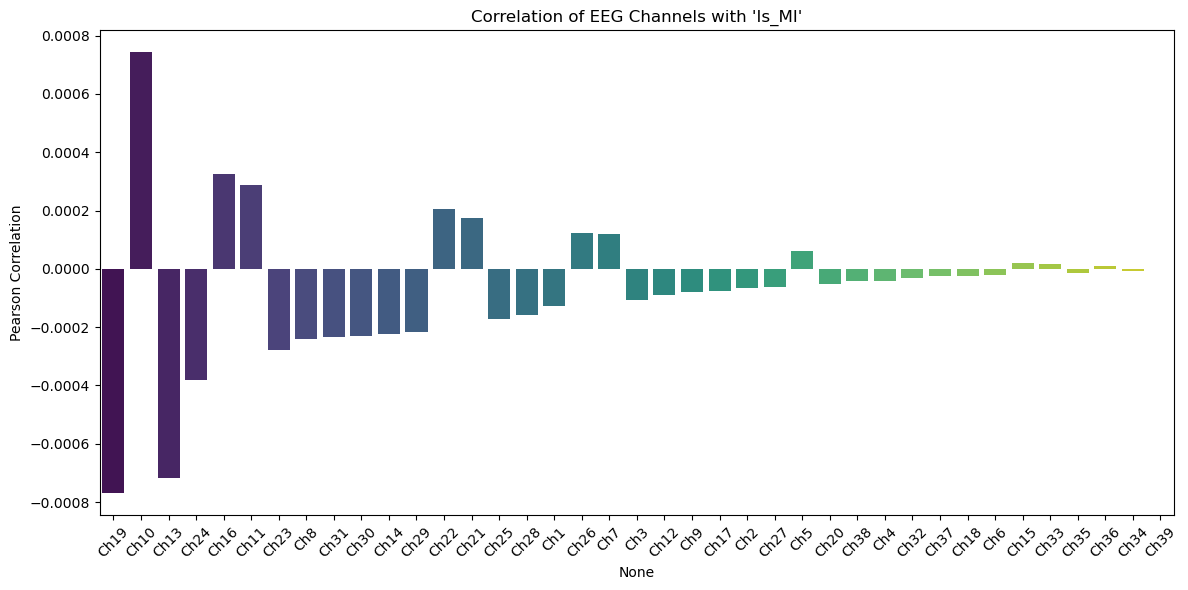

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


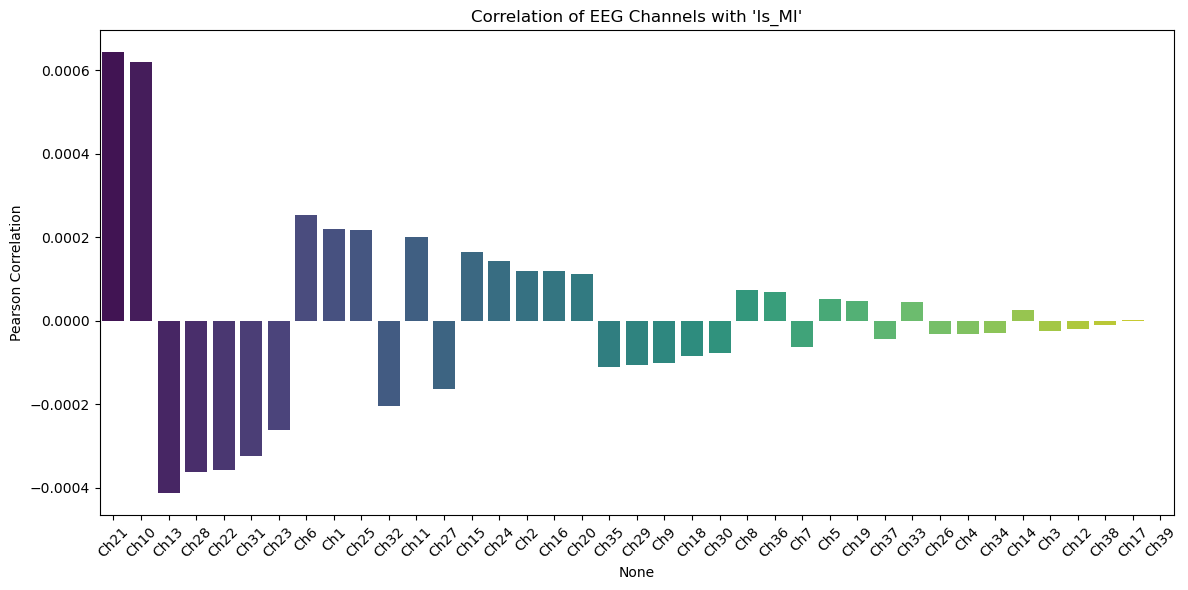

In [46]:
plot_correlation(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0])
plot_correlation(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1])

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


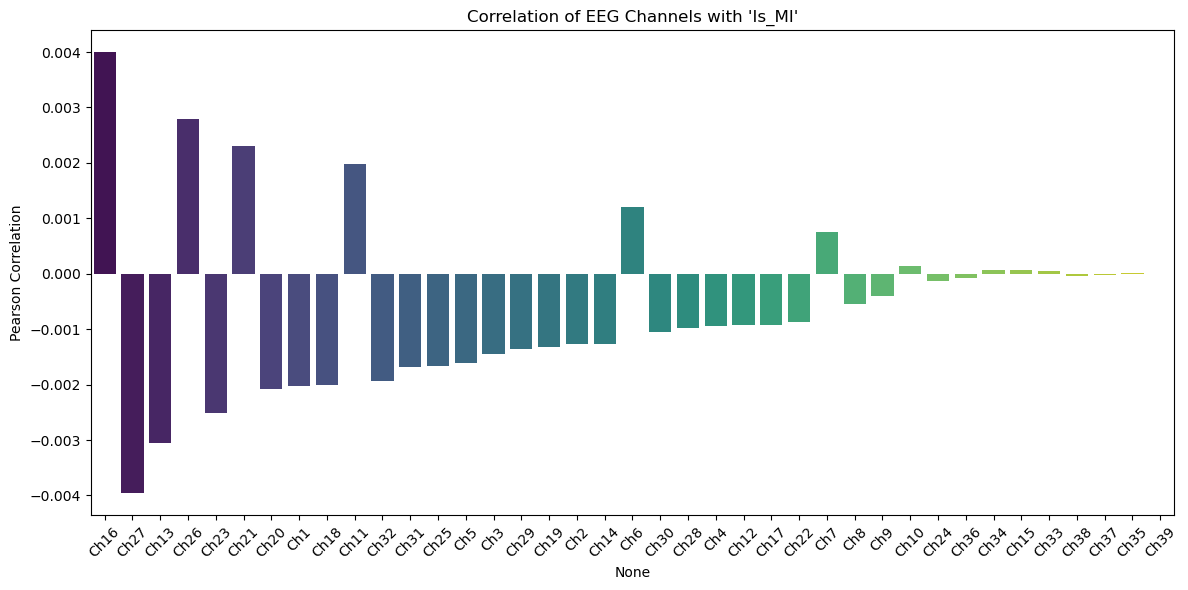

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


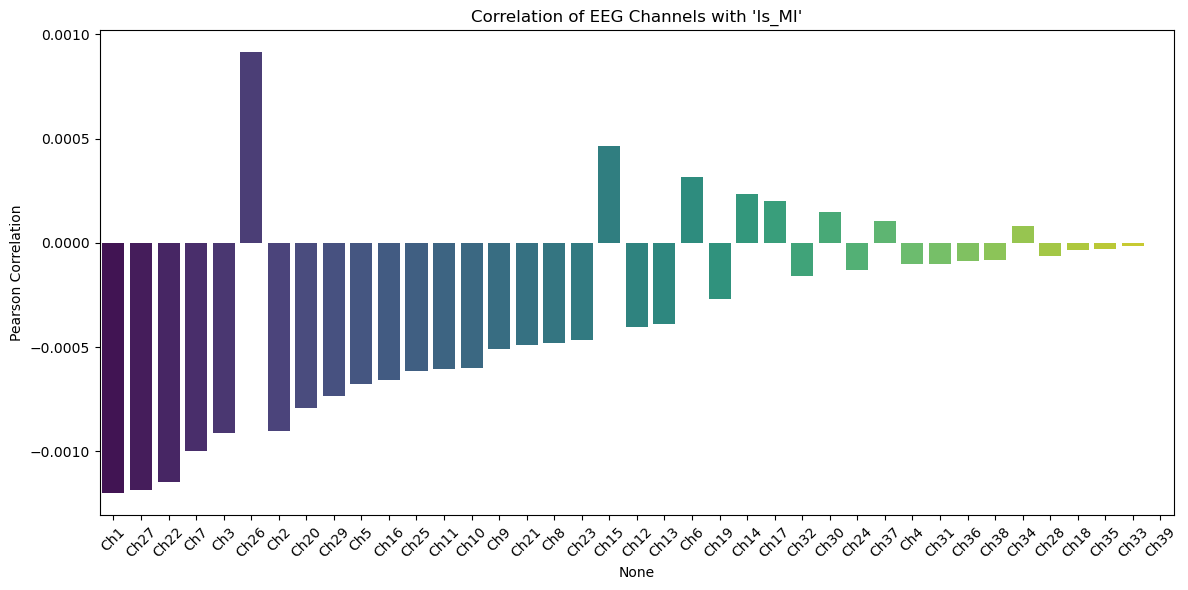

In [47]:
plot_correlation(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0])
plot_correlation(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1])

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


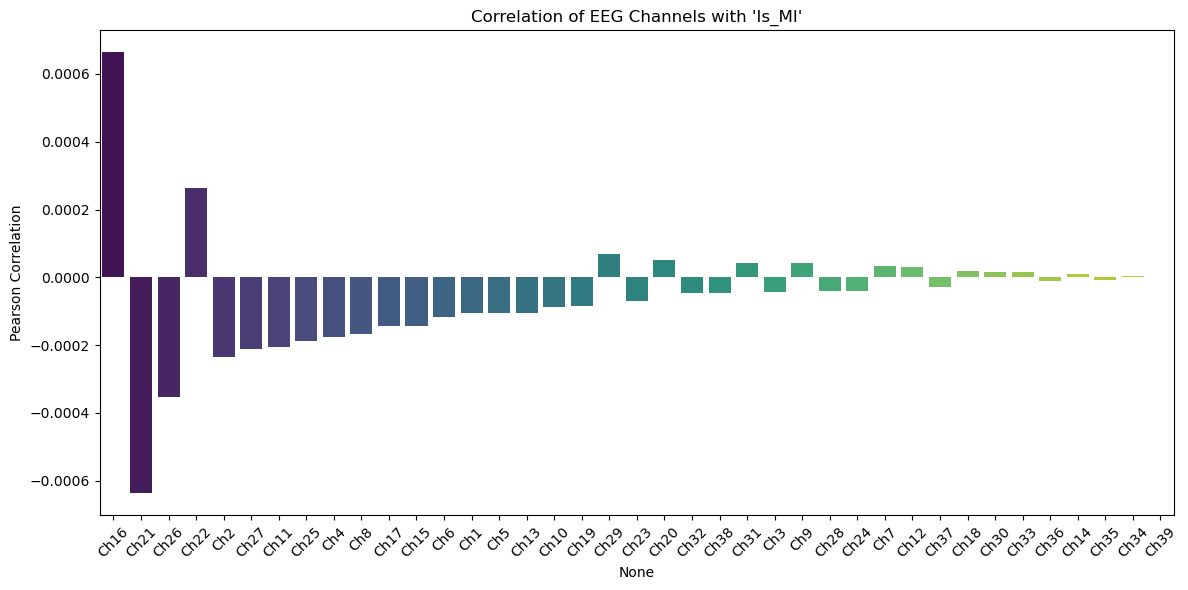

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


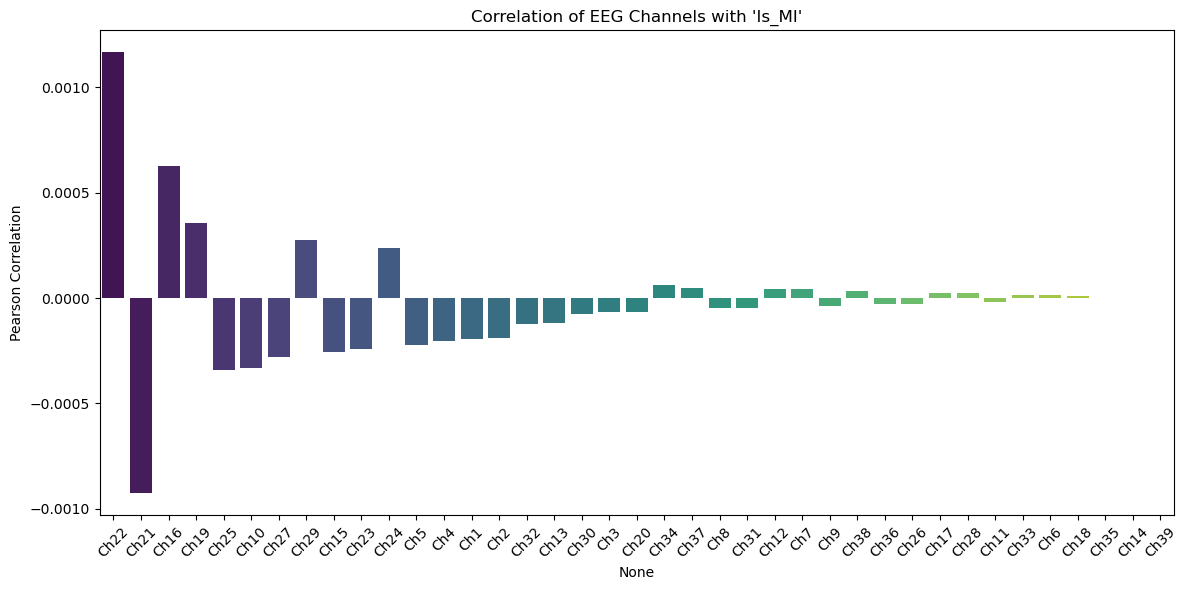

In [48]:
plot_correlation(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0])
plot_correlation(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1])

In [54]:
banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("Top 10 Correlations for Subject 1031 S1R1 (FES):")
print(top10_corr)

banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("\nTop 10 Correlations for Subject 1031 S1R2 (No FES):")
print(top10_corr)

Top 10 Correlations for Subject 1031 S1R1 (FES):
Ch38_90-100Hz    -0.453670
Ch36_80-90Hz     -0.417868
Ch3_170-180Hz    -0.393649
Ch36_170-180Hz   -0.386314
Ch18_20-30Hz     -0.386176
Ch34_200-210Hz   -0.385852
Ch30_140-150Hz   -0.377909
Ch3_140-150Hz    -0.362719
Ch2_170-180Hz    -0.359234
Ch2_30-40Hz      -0.358934
Name: Is_MI, dtype: float64

Top 10 Correlations for Subject 1031 S1R2 (No FES):
Ch36_180-190Hz   -0.314965
Ch35_230-240Hz   -0.297138
Ch38_190-200Hz   -0.293404
Ch8_180-190Hz     0.291074
Ch7_130-140Hz     0.289913
Ch8_240-250Hz     0.289646
Ch3_200-210Hz     0.288923
Ch8_50-60Hz       0.288233
Ch7_100-110Hz     0.287170
Ch8_190-200Hz     0.286599
Name: Is_MI, dtype: float64


In [55]:
banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("Top 10 Correlations for Subject 1032 S1R1 (FES):")
print(top10_corr)

banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("\nTop 10 Correlations for Subject 1032 S1R2 (No FES):")
print(top10_corr)

Top 10 Correlations for Subject 1032 S1R1 (FES):
Ch37_210-220Hz    0.549200
Ch22_10-20Hz     -0.515924
Ch37_240-250Hz    0.514610
Ch28_10-20Hz     -0.512781
Ch10_20-30Hz     -0.511737
Ch37_180-190Hz    0.508669
Ch36_40-50Hz     -0.486367
Ch37_150-160Hz    0.479195
Ch5_30-40Hz      -0.475656
Ch10_40-50Hz     -0.470507
Name: Is_MI, dtype: float64

Top 10 Correlations for Subject 1032 S1R2 (No FES):
Ch27_10-20Hz     -0.557475
Ch23_10-20Hz     -0.550045
Ch2_70-80Hz      -0.499749
Ch22_10-20Hz     -0.489447
Ch37_120-130Hz   -0.453725
Ch1_20-30Hz      -0.438887
Ch3_70-80Hz      -0.430118
Ch21_10-20Hz     -0.420766
Ch2_20-30Hz      -0.414284
Ch6_20-30Hz      -0.410059
Name: Is_MI, dtype: float64


In [56]:
banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("Top 10 Correlations for Subject 1033 S1R1 (FES):")
print(top10_corr)

banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("\nTop 10 Correlations for Subject 1033 S1R2 (No FES):")
print(top10_corr)

Top 10 Correlations for Subject 1033 S1R1 (FES):
Ch22_10-20Hz     -0.476609
Ch16_10-20Hz     -0.458272
Ch36_180-190Hz    0.413496
Ch11_10-20Hz     -0.346479
Ch26_10-20Hz     -0.341583
Ch6_10-20Hz      -0.335381
Ch26_240-250Hz    0.334031
Ch17_10-20Hz     -0.332780
Ch26_200-210Hz    0.316300
Ch26_230-240Hz    0.315421
Name: Is_MI, dtype: float64

Top 10 Correlations for Subject 1033 S1R2 (No FES):
Ch22_10-20Hz   -0.511524
Ch15_10-20Hz   -0.491506
Ch10_10-20Hz   -0.437829
Ch5_10-20Hz    -0.437469
Ch16_20-30Hz   -0.399313
Ch21_10-20Hz   -0.395256
Ch2_10-20Hz    -0.394646
Ch17_10-20Hz   -0.383096
Ch3_10-20Hz    -0.377444
Ch24_10-20Hz   -0.367612
Name: Is_MI, dtype: float64


Next, combine sessions / runs / subjects and find correlations / fisher scores to compare

Later, we can also make models to find classification metrics when using FES/no FES (LOPO?)